In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from datetime import datetime
# from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from xgboost import DMatrix

import re
import ast
import warnings
from collections import Counter

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### Import & Info

In [2]:
df = pd.read_csv('/Users/jiayi/Desktop/B_CS671/kaggle/raw_data/train.csv')
df.columns.shape ## 48
df.shape    ## (15441, 48)
df.head(1)

# df.columns
# df.dtypes
# df.info()

info_df = pd.DataFrame({'DataType': df.dtypes, 'NumOfNA': df.isna().sum(), '%OfNA': df.isnull().mean()*100})
print(info_df)
df.describe()


                                             DataType  NumOfNA     %OfNA
id                                              int64        0  0.000000
scrape_id                                       int64        0  0.000000
last_scraped                                   object        0  0.000000
name                                           object        0  0.000000
description                                    object      225  1.457160
picture_url                                    object        0  0.000000
host_id                                         int64        0  0.000000
host_name                                      object        0  0.000000
host_since                                     object        0  0.000000
host_is_superhost                              object      428  2.771841
host_listings_count                           float64        0  0.000000
host_total_listings_count                     float64        0  0.000000
host_verifications                             obje

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,15441.000000,1.544100e+04,1.544100e+04,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15322.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,1.544100e+04,1.544100e+04,15441.000000,1.544100e+04,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000
mean,7720.000000,2.023090e+13,1.814302e+08,117.346286,174.791270,34.049962,-118.340461,5.079399,2.759627,1.961337,16.638430,513.701379,17.265592,22.390389,2.788482e+05,2.788735e+05,21.821423,2.788605e+05,15.716728,34.704099,55.518425,203.750988,30.985169,8.514086,0.817564,24.701638,22.946571,1.644194,0.086393
std,4457.577089,5.031413e+00,1.756812e+08,597.470382,813.486601,0.140982,0.169908,3.223242,1.933759,1.619984,30.164661,439.259357,35.177024,52.620049,2.443954e+07,2.443954e+07,51.451889,2.443954e+07,12.143686,23.392779,34.384775,134.904394,67.792226,15.477778,1.522905,89.448423,89.248426,7.342761,1.475507
min,0.000000,2.023090e+13,7.670000e+02,0.000000,0.000000,33.338600,-118.916410,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3860.000000,2.023090e+13,2.372231e+07,1.000000,2.000000,33.997742,-118.438268,2.000000,1.000000,0.000000,2.000000,90.000000,2.000000,2.000000,3.650000e+02,3.650000e+02,2.000000,3.650000e+02,1.000000,9.000000,25.000000,82.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,7720.000000,2.023090e+13,1.084975e+08,3.000000,5.000000,34.061950,-118.361900,4.000000,2.000000,2.000000,5.000000,365.000000,4.000000,6.000000,1.125000e+03,1.125000e+03,5.000000,1.125000e+03,17.000000,41.000000,67.000000,215.000000,5.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000
75%,11580.000000,2.023090e+13,3.444546e+08,14.000000,23.000000,34.108080,-118.259989,7.000000,4.000000,3.000000,30.000000,1125.000000,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,29.000000,58.000000,88.000000,343.000000,29.000000,10.000000,1.000000,11.000000,8.000000,0.000000,0.000000
max,15440.000000,2.023090e+13,5.349146e+08,4576.000000,9168.000000,34.797857,-117.653360,16.000000,50.000000,5.000000,1124.000000,3022.000000,1124.000000,1124.000000,2.147484e+09,2.147484e+09,1124.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,1118.000000,183.000000,16.000000,692.000000,692.000000,78.000000,44.000000


### Clean

#### date

In [4]:
## datetime: host_since; 
date_list = pd.to_datetime(df['host_since'])
today = datetime.today()
date_list    ## 2018-07-27 alike
time_list = (today - date_list).dt.days
print(time_list)
print(time_list.dtypes)   ## int64
print(time_list.isna().sum())    ## 0 na


0        1940
1        3774
2        1608
3         747
4         271
         ... 
15436    1164
15437    1960
15438    2962
15439    1690
15440    2993
Name: host_since, Length: 15441, dtype: int64
int64
0


#### binary

In [5]:
## binary
df.host_is_superhost.isna().sum() 
## df.host_is_superhost.value_counts()
## f    10073
## t     4940  NA ## 428

df.host_has_profile_pic.isna().sum()   # 0
df.host_has_profile_pic.value_counts()
## t    15103
## f      338

df.host_identity_verified.value_counts()  ## 0 na
## t    13807
## f     1634

df.has_availability.value_counts()    ## 0 na
## t    14445
## f      996

df.instant_bookable.isna().sum()   ## 0 na
## f    11047
## t     4394


0

#### feature engineer var

In [3]:
## name: filter and convert to list?? 
def remove_symbols_keep_spaces(x):
    return re.sub(r"[^a-zA-Z0-9]+", ' ', x)
clean_sample1 = (df['name'].apply(remove_symbols_keep_spaces)).astype(str)
# print(type(clean_sample1[0]))  ## <class 'str'>
# print(clean_sample1.head())
# print(clean_sample1.isna().sum())    ## 0


def parse_names(x):
    split_dat = x.split('·')
    rating, bedroom, bed, bath_num, bath_share = np.nan, np.nan, np.nan, np.nan, np.nan
    for dat in split_dat:
        dat = dat.strip()
        if '★' in dat:
            rating = dat.replace('★', '')
        elif 'bedroom' in dat:
            bedroom = (re.sub(r'[^\d.]+', '', dat)).strip()
        elif 'bed' in dat and 'bedroom' not in dat:
            bed = (re.sub(r'[^\d.]+', '', dat)).strip()
        elif 'bath' in dat:
            bath_num = (re.sub(r'[^\d.]+', '', dat)).strip()
            bath_share = 1 if 'share' in dat else 0
    return rating, bedroom, bed, bath_num, bath_share

def extract_name_column_info(df):
    processed_name_df = pd.DataFrame(df['name'].apply(lambda x: pd.Series(parse_names(x))))
    processed_name_df.columns = ['rating', 'bedrooms', 'beds', 'bath_num', 'bath_share']
    return processed_name_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

df_sample = extract_name_column_info(df)
df_sample.head(20)
# 1. df_sample['share_count'] = df_sample['beds'].apply(lambda x: x.count('share') if isinstance(x, str) else 0)
# print(df_sample['share_count'])    
# 2. condition = df_sample['bath_type'] != df_sample['bathrooms_text']
# print(df_sample[condition])
# ## beds shared:   0 
# ## bedrooms shared:  0
# ## bath 2 cols sim: 100% (printed are nas)
info_df = pd.DataFrame({'DataType': df_sample.dtypes, 'NumOfNA': df_sample.isna().sum(), '%OfNA': df_sample.isnull().mean()*100})
print(info_df)


           DataType  NumOfNA      %OfNA
rating      float64     6438  41.694191
bedrooms    float64      896   5.802733
beds        float64      119   0.770675
bath_num    float64       34   0.220193
bath_share  float64        8   0.051810


In [7]:
## description ## remove specified strings
clean_description = df['description'].str.replace('<br />', ' ').str.replace('</b>', ' ').str.replace('<b>', ' ')
print(clean_description.head())

print(type(clean_description[5]))  ## str
clean_description[5]   ## note: need remove symbols
print(clean_description.isna().sum())      ## 225

0    Beautifully designed decor, lighting and enter...
1    The location is great - the apt is HUGH 1877 S...
2    315 Eucalyptus Lower Spacious, Remodeled Avalo...
3    Close to almost everything when you stay at th...
4    Enjoy the thrill of staying in a hotel located...
Name: description, dtype: object
<class 'str'>
225


In [188]:
## host_verifications
list_representation = ast.literal_eval(df.host_verifications[0])
print(list_representation)
for i in list_representation:
    print(i)

host_veri_lst = df.host_verifications.apply(lambda x: ast.literal_eval(x))   ##******
print(host_veri_lst.head())

for i in host_veri_lst[0]:
    print(i, type(i))
print(type(host_veri_lst[0]))   ## list of str
print(host_veri_lst.isna().sum())    ##  0

## one hot encoding
all_append = [item for sublist in host_veri_lst for item in sublist]
contact_counts = Counter(all_append)
print(contact_counts)


['email', 'phone']
email
phone
0                [email, phone]
1                [email, phone]
2    [email, phone, work_email]
3                [email, phone]
4                [email, phone]
Name: host_verifications, dtype: object
email <class 'str'>
phone <class 'str'>
<class 'list'>
0
Counter({'phone': 15417, 'email': 14094, 'work_email': 2212})


In [194]:
## neighbourhood_cleansed
df.neighbourhood_cleansed.value_counts()   ## 0 na
df.neighbourhood_cleansed.astype(str)
print(df.neighbourhood_cleansed.value_counts())

Venice            759
Santa Monica      573
Long Beach        570
West Hollywood    561
Beverly Hills     545
                 ... 
Citrus              1
Val Verde           1
Rolling Hills       1
Angeles Crest       1
Elizabeth Lake      1
Name: neighbourhood_cleansed, Length: 259, dtype: int64


In [193]:
## neighbourhood_group_cleansed
df.neighbourhood_group_cleansed.isna().sum()   ## 0 na
type(df.neighbourhood_group_cleansed[0])  ## str
print(df.neighbourhood_group_cleansed.value_counts())

City of Los Angeles     7726
Other Cities            6361
Unincorporated Areas    1354
Name: neighbourhood_group_cleansed, dtype: int64


In [286]:
## property_type
print(df.property_type[0])
type(df.property_type[0]) ## str
print(df.property_type.isna().sum())  ## 0
print(df.property_type.value_counts())

Shared room in home
0
Entire home                      5791
Entire rental unit               3723
Private room in home              974
Entire condo                      776
Entire guesthouse                 664
                                 ... 
Entire chalet                       1
Shared room in guesthouse           1
Shared room in boutique hotel       1
Private room in farm stay           1
Room in hostel                      1
Name: property_type, Length: 84, dtype: int64


In [13]:
## room_type
print(df.room_type[0])
print(df.room_type.isna().sum())  ## 0
print(df.room_type.value_counts())


# Apply one-hot encoding
df_encoded = pd.get_dummies(df['room_type'], prefix='category')
df_encoded

print(df.property_type.value_counts())


Shared room
0
Entire home/apt    13067
Private room        2233
Shared room          116
Hotel room            25
Name: room_type, dtype: int64
Entire home                      5791
Entire rental unit               3723
Private room in home              974
Entire condo                      776
Entire guesthouse                 664
                                 ... 
Entire chalet                       1
Shared room in guesthouse           1
Shared room in boutique hotel       1
Private room in farm stay           1
Room in hostel                      1
Name: property_type, Length: 84, dtype: int64


In [292]:
## bathrooms_text
print(df.bathrooms_text[0])
print(type(df.bathrooms_text[0]))
print(df.bathrooms_text.isna().sum())    ## 8
print(df.bathrooms_text.head())

1 shared bath
<class 'str'>
8
0    1 shared bath
1          2 baths
2          2 baths
3        2.5 baths
4           1 bath
Name: bathrooms_text, dtype: object


In [290]:
## amenities
amenit_lst = df.amenities.apply(lambda x: ast.literal_eval(x))
print(amenit_lst.head())

for i in amenit_lst[0]:
    print(i, type(i))
print(type(amenit_lst[0]))
print(amenit_lst.isna().sum())   ## 0

all_append = [item for sublist in amenit_lst for item in sublist]
amenit_counts = Counter(all_append)
print(amenit_counts)

0    [Stove, Iron, Window guards, Smoking allowed, ...
1    [Stove, Carbon monoxide alarm, Iron, Freezer, ...
2    [Stove, Carbon monoxide alarm, Iron, Host gree...
3    [Free parking on premises, Smoke alarm, Carbon...
4    [Carbon monoxide alarm, Iron, Air conditioning...
Name: amenities, dtype: object
Stove <class 'str'>
Iron <class 'str'>
Window guards <class 'str'>
Smoking allowed <class 'str'>
Microwave <class 'str'>
Luggage dropoff allowed <class 'str'>
Bathtub <class 'str'>
Bed linens <class 'str'>
First aid kit <class 'str'>
Pets allowed <class 'str'>
Essentials <class 'str'>
Refrigerator <class 'str'>
TV with standard cable <class 'str'>
Shower gel <class 'str'>
Fire extinguisher <class 'str'>
Room-darkening shades <class 'str'>
Dryer <class 'str'>
Extra pillows and blankets <class 'str'>
Hot water <class 'str'>
Oven <class 'str'>
Free street parking <class 'str'>
Long term stays allowed <class 'str'>
Washer <class 'str'>
Backyard <class 'str'>
Shampoo <class 'str'>
Kitchen <

#### float & int

In [15]:
## host_id
# len(df[df['host_id'].isna()])  ## 0 na
duplicates_count = df[df['host_id'].duplicated(keep=False)].groupby('host_id').size()
print(duplicates_count)

host_id
33921        2
55411        3
57161        8
66096        2
69546        2
            ..
529727141    2
530389817    2
530746410    3
533136918    4
534446107    2
Length: 1786, dtype: int64


In [283]:
# missing_percentages
missing_percentages = df.isnull().mean() * 100
print(missing_percentages[missing_percentages>0])
## description                                     1.457160
## host_is_superhost                               2.771841
## bathrooms_text                                  0.051810
## beds                                            0.770675

description          1.457160
host_is_superhost    2.771841
bathrooms_text       0.051810
beds                 0.770675
dtype: float64


In [109]:
## beds
# IQR rules
q1 = np.quantile(df_clean['beds'], 0.25)
q3 = np.quantile(df_clean['beds'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

#list all the outlier
out_beds = df_clean.loc[(df_clean['beds']<=lower_bound) | (df_clean['beds']>=upper_bound)]
print(out_beds.shape) ## 158
out_beds

3.0 8.5 -3.5
(158, 41)


,price,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_since,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,description,name,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,amenities
114,5.0,1.0,1.0,1.0,1.0,0.0,2051.0,5.0,5.0,34.132590,-118.361790,16.0,9.0,30.0,365.0,30.0,30.0,1125.0,1125.0,30.0,1125.0,20.0,50.0,74.0,161.0,14.0,14.0,0.0,2.0,2.0,0.0,0.0,Welcome to The One and Only Super Star Mansion...,Villa in Los Angeles 4 93 9 bedrooms 9 beds 8 ...,"[email, phone]",Studio City,City of Los Angeles,Entire villa,Entire home/apt,8.5 baths,"[Stove, Carbon monoxide alarm, Iron, Freezer, ..."
117,0.0,0.0,1.0,1.0,0.0,0.0,4169.0,15.0,45.0,34.020200,-118.315820,4.0,18.0,30.0,90.0,30.0,30.0,90.0,90.0,30.0,90.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,15.0,0.0,4.0,11.0,The Cottage is a quaint home built in the mid-...,Home in Los Angeles 4 bedrooms 18 beds 2 share...,"[email, phone]",Exposition Park,City of Los Angeles,Shared room in home,Shared room,2 shared baths,"[Stove, Carbon monoxide alarm, Iron, Gym, Air ..."
272,3.0,1.0,1.0,1.0,1.0,1.0,3996.0,5.0,5.0,33.761032,-118.142494,12.0,9.0,2.0,1125.0,2.0,4.0,1125.0,1125.0,3.8,1125.0,26.0,56.0,82.0,346.0,65.0,27.0,3.0,5.0,5.0,0.0,0.0,Just a block from the beach and upscale Belmon...,Home in Long Beach 4 97 4 bedrooms 9 beds 3 baths,"[email, phone]",Long Beach,Other Cities,Entire home,Entire home/apt,3 baths,"[Carbon monoxide alarm, Iron, Children’s books..."
388,5.0,1.0,1.0,1.0,1.0,0.0,3451.0,8.0,8.0,34.037950,-118.607400,10.0,11.0,3.0,25.0,3.0,3.0,25.0,25.0,3.0,25.0,28.0,58.0,83.0,173.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,PLEASE MESSAGE US RE: WEEKLY PROMOTIONS BEFORE...,Villa in Malibu 5 0 5 bedrooms 11 beds 3 baths,"[email, phone]",Malibu,Other Cities,Entire villa,Entire home/apt,3 baths,"[Exercise equipment: treadmill, yoga mat, Carb..."
403,3.0,0.0,1.0,1.0,1.0,0.0,228.0,1.0,1.0,34.218088,-118.539422,16.0,9.0,2.0,1125.0,1.0,1.0,1125.0,1125.0,1.0,1125.0,13.0,22.0,40.0,310.0,18.0,18.0,5.0,1.0,1.0,0.0,0.0,Perfect destination for family & friends to re...,Home in Los Angeles 4 78 4 bedrooms 9 beds 2 b...,"[email, phone]",Reseda,City of Los Angeles,Entire home,Entire home/apt,2 baths,"[Carbon monoxide alarm, Iron, Freezer, Dining ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15102,5.0,1.0,1.0,1.0,1.0,0.0,1627.0,17.0,18.0,34.089241,-118.400426,16.0,11.0,3.0,365.0,2.0,5.0,365.0,365.0,3.1,365.0,24.0,48.0,75.0,255.0,0.0,0.0,0.0,17.0,17.0,0.0,0.0,Escape to opulent Sunset Plaza Gated Estate. P...,Villa in Beverly Hills New 7 bedrooms 11 beds ...,"[email, phone]",Beverly Hills,Other Cities,Entire villa,Entire home/apt,7 baths,"[Courtyard view, Carbon monoxide alarm, Stove,..."
15120,0.0,0.0,1.0,1.0,1.0,1.0,5232.0,10.0,57.0,34.048700,-118.234570,2.0,16.0,30.0,365.0,30.0,30.0,365.0,365.0,30.0,365.0,30.0,60.0,90.0,309.0,117.0,0.0,0.0,8.0,0.0,0.0,4.0,PodShare is a co-living space in the heart of ...,Hostel in Los Angeles 4 57 1 bedroom 16 beds 2...,"[email, phone]",Downtown,City of Los Angeles,Room in hostel,Hotel room,2 baths,"[Dedicated workspace, Iron, Dishes and silverw..."
15162,5.0,1.0,1.0,1.0,1.0,0.0,2268.0,10.0,10.0,34.098830,-118.381310,16.0,13.0,3.0,365.0,3.0,3.0,365.0,365.0,3.0,365.0,30.0,60.0,90.0,365.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,The perfect choice for gathering friends and f...,Hom

In [129]:
## number of reviews
# IQR rules
q1 = np.quantile(df_clean['number_of_reviews_l30d'], 0.25)
q3 = np.quantile(df_clean['number_of_reviews_l30d'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
rew30 = df_clean.loc[(df_clean['number_of_reviews_l30d']<=lower_bound) | (df_clean['number_of_reviews_l30d']>=upper_bound)]
lst_rew30 = list(rew30.index)

## 2
# IQR rules
q1 = np.quantile(df_clean['number_of_reviews_ltm'], 0.25)
q3 = np.quantile(df_clean['number_of_reviews_ltm'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
rewtm = df_clean.loc[(df_clean['number_of_reviews_ltm']<=lower_bound) | (df_clean['number_of_reviews_ltm']>=upper_bound)]
lst_rewtm = list(rewtm.index)

## 3
# IQR rules
q1 = np.quantile(df_clean['number_of_reviews'], 0.25)
q3 = np.quantile(df_clean['number_of_reviews'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
rewall = df_clean.loc[(df_clean['number_of_reviews']<=lower_bound) | (df_clean['number_of_reviews']>=upper_bound)]
lst_rewall = list(rewall.index)


## intersection
# print(len(list(set(lst_rew30).intersection(lst_rewtm))), len(lst_rew30), len(lst_rewtm))
## 1141 1974 1973
# print(len(list(set(lst_rewtm).intersection(lst_rewall))), len(lst_rewtm), len(lst_rewall))
## 1004 1973 1885

print(
    'intersected outliers: \n  ', 
    len(list(set(set(lst_rewtm).intersection(lst_rewall)).intersection(lst_rew30))), 
    '\nnumber_of_reviews_l30d outliers: \n  ', len(lst_rew30), 
    '\nnumber_of_reviews_ltm outliers: \n  ', len(lst_rewtm),
    '\nnumber_of_reviews outliers: \n  ', len(lst_rewall),
    )

intersected outliers: 
   617 
number_of_reviews_l30d outliers: 
   1974 
number_of_reviews_ltm outliers: 
   1973 
number_of_reviews outliers: 
   1885


In [281]:
## calculated_host_listings_count
# IQR rules
q1 = np.quantile(df['calculated_host_listings_count'], 0.25)
q3 = np.quantile(df['calculated_host_listings_count'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
host_lst = df.loc[(df['calculated_host_listings_count']<=lower_bound) | (df['calculated_host_listings_count']>=upper_bound)]
host_lst_idx = list(host_lst.index)


# IQR rules
q1 = np.quantile(df['calculated_host_listings_count_entire_homes'], 0.25)
q3 = np.quantile(df['calculated_host_listings_count_entire_homes'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
host_ent_lst = df.loc[(df['calculated_host_listings_count_entire_homes']<=lower_bound) | (df['calculated_host_listings_count_entire_homes']>=upper_bound)]
ent_lst_idx = list(host_ent_lst.index)


# IQR rules
q1 = np.quantile(df['calculated_host_listings_count_private_rooms'], 0.25)
q3 = np.quantile(df['calculated_host_listings_count_private_rooms'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
host_pri_lst = df.loc[(df['calculated_host_listings_count_private_rooms']<=lower_bound) | (df['calculated_host_listings_count_private_rooms']>=upper_bound)]
pri_lst_idx = list(host_pri_lst.index)


# IQR rules
q1 = np.quantile(df['calculated_host_listings_count_shared_rooms'], 0.25)
q3 = np.quantile(df['calculated_host_listings_count_shared_rooms'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
host_shr_lst = df.loc[(df['calculated_host_listings_count_shared_rooms']<=lower_bound) | (df['calculated_host_listings_count_shared_rooms']>=upper_bound)]
shr_lst_idx = list(host_shr_lst.index)

## intersection
print('intersect:', len(list(set(host_lst_idx).intersection(ent_lst_idx))), '|host_lst_idx:', len(host_lst_idx), '|entire_lst_idx:', len(ent_lst_idx))
print('intersect:', len(list(set(host_lst_idx).intersection(pri_lst_idx))), '|host_lst_idx:', len(host_lst_idx), '|private_lst_idx:', len(pri_lst_idx))
print('intersect:', len(list(set(host_lst_idx).intersection(shr_lst_idx))), '|host_lst_idx:', len(host_lst_idx), '|share_lst_idx:', len(shr_lst_idx))


intersect: 2209 |host_lst_idx: 2367 |entire_lst_idx: 2667
intersect: 2367 |host_lst_idx: 2367 |private_lst_idx: 15441
intersect: 2367 |host_lst_idx: 2367 |share_lst_idx: 15441


In [178]:
## accommodates
# IQR rules
q1 = np.quantile(df_clean['accommodates'], 0.25)
q3 = np.quantile(df_clean['accommodates'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
acm_lst = df_clean.loc[(df_clean['accommodates']<=lower_bound) | (df_clean['accommodates']>=upper_bound)]
acm_lst_idx = list(acm_lst.index)

# IQR rules
q1 = np.quantile(df_clean['minimum_nights'], 0.25)
q3 = np.quantile(df_clean['minimum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
minn_lst = df_clean.loc[(df_clean['minimum_nights']<=lower_bound) | (df_clean['minimum_nights']>=upper_bound)]
minn_lst_idx = list(minn_lst.index)


# IQR rules
q1 = np.quantile(df_clean['maximum_nights'], 0.25)
q3 = np.quantile(df_clean['maximum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
maxn_lst = df_clean.loc[(df_clean['maximum_nights']<=lower_bound) | (df_clean['maximum_nights']>=upper_bound)]
maxn_lst_idx = list(maxn_lst.index)

# IQR rules
q1 = np.quantile(df_clean['minimum_minimum_nights'], 0.25)
q3 = np.quantile(df_clean['minimum_minimum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
minmin_lst = df_clean.loc[(df_clean['minimum_minimum_nights']<=lower_bound) | (df_clean['minimum_minimum_nights']>=upper_bound)]
minmin_lst_idx = list(minmin_lst.index)

# IQR rules
q1 = np.quantile(df_clean['maximum_minimum_nights'], 0.25)
q3 = np.quantile(df_clean['maximum_minimum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
maxmin_lst = df_clean.loc[(df_clean['maximum_minimum_nights']<=lower_bound) | (df_clean['maximum_minimum_nights']>=upper_bound)]
maxmin_lst_idx = list(maxmin_lst.index)


# IQR rules
q1 = np.quantile(df_clean['minimum_maximum_nights'], 0.25)
q3 = np.quantile(df_clean['minimum_maximum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
minmax_lst = df_clean.loc[(df_clean['minimum_maximum_nights']<=lower_bound) | (df_clean['minimum_maximum_nights']>=upper_bound)]
minmax_lst_idx = list(minmax_lst.index)

# IQR rules
q1 = np.quantile(df_clean['maximum_maximum_nights'], 0.25)
q3 = np.quantile(df_clean['maximum_maximum_nights'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
maxmax_lst = df_clean.loc[(df_clean['maximum_maximum_nights']<=lower_bound) | (df_clean['maximum_maximum_nights']>=upper_bound)]
maxmax_lst_idx = list(maxmax_lst.index)

# IQR rules
q1 = np.quantile(df_clean['minimum_nights_avg_ntm'], 0.25)
q3 = np.quantile(df_clean['minimum_nights_avg_ntm'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
minavg_lst = df_clean.loc[(df_clean['minimum_nights_avg_ntm']<=lower_bound) | (df_clean['minimum_nights_avg_ntm']>=upper_bound)]
minavg_lst_idx = list(minavg_lst.index)

# IQR rules
q1 = np.quantile(df_clean['maximum_nights_avg_ntm'], 0.25)
q3 = np.quantile(df_clean['maximum_nights_avg_ntm'], 0.75)
#finding the IQR region
iqr = q3 - q1
#finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)

#list all the outlier
maxavg_lst = df_clean.loc[(df_clean['maximum_nights_avg_ntm']<=lower_bound) | (df_clean['maximum_nights_avg_ntm']>=upper_bound)]
maxavg_lst_idx = list(maxavg_lst.index)

print('accommodates outliers: \n  ', len(acm_lst_idx), 
        '\nbeds outliers: \n  ', len(out_beds),
        '\nminimum_nights outliers: \n  ', len(minn_lst_idx),
        '\nmaximum_nights outliers:  \n  ', len(maxn_lst_idx),
        '\nminimum_minimum_nights outliers:  \n  ', len(minmin_lst_idx),
        '\nmaximum_minimum_nights outliers:  \n  ', len(maxmin_lst_idx),
        '\nminimum_maximum_nights outliers:  \n  ', len(minmax_lst_idx), 
        '\nmaximum_maximum_nights outliers:  \n  ', len(maxmax_lst_idx), 
        '\nminimum_nights_avg_ntm outliers:  \n  ', len(minavg_lst_idx), 
        '\nmaximum_nights_avg_ntm outliers:  \n  ', len(maxavg_lst_idx))   ##13-16

accommodates outliers: 
   794 
beds outliers: 
   158 
minimum_nights outliers: 
   140 
maximum_nights outliers:  
   2 
minimum_minimum_nights outliers:  
   178 
maximum_minimum_nights outliers:  
   389 
minimum_maximum_nights outliers:  
   4 
maximum_maximum_nights outliers:  
   4 
minimum_nights_avg_ntm outliers:  
   378 
maximum_nights_avg_ntm outliers:  
   4


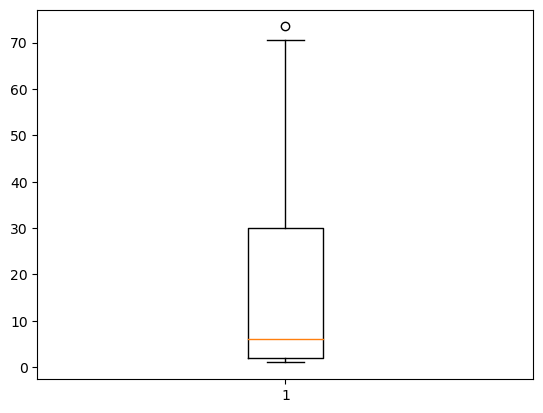

In [182]:
## box plot tests
plt.boxplot(df_clean['maximum_minimum_nights'])
plt.show()


### Finalize

In [356]:
# def preprocessing

df_clean = df.copy()

## change date
df_clean['host_since'] = time_list
## encoding binary
df_clean['host_is_superhost'] = df_clean.host_is_superhost.replace({'t': 1, 'f': 0})
df_clean['host_has_profile_pic'] = df_clean.host_has_profile_pic.replace({'t': 1, 'f': 0})
df_clean['host_identity_verified'] = df_clean.host_identity_verified.replace({'t': 1, 'f': 0})
df_clean['has_availability'] = df_clean.has_availability.replace({'t': 1, 'f': 0})
df_clean['instant_bookable'] = df_clean.instant_bookable.replace({'t': 1, 'f': 0})
## clean text
df_clean['description'] = clean_description
df_clean['host_verifications'] = host_veri_lst
df_clean['amenities'] = amenit_lst

## drop insignificant
df_clean = df_clean.drop(['id', 'scrape_id', 'last_scraped', 'picture_url', 
                            'calendar_last_scraped', 'host_name'], axis=1)
## drop na observations
df_clean = df_clean.dropna(subset = ['description', 'bathrooms_text'])
print(df_clean.host_has_profile_pic.value_counts())
print(df_clean.host_is_superhost.value_counts())

## imputation, separation
dropped_cols = ['description', 'name', 'host_verifications', 'neighbourhood_cleansed',
                'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text','amenities']
df_subset = df_clean.drop(columns = embedding_cols)
df_dropped = df_clean[embedding_cols]

## impute na *1
mice_imputer = IterativeImputer(imputation_order='ascending', random_state=42)
imputed_values = mice_imputer.fit_transform(df_subset)
df_imputed = pd.DataFrame(imputed_values, columns=df_subset.columns, index=df_subset.index)
df_imputed['host_is_superhost'] = df_imputed['host_is_superhost'].round()

## impute outlier *2
outlier_lst = ['beds', 'accommodates', 'minimum_nights', 'maximum_nights', 
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
for col in outlier_lst:
    Q1 = df_imputed[col].quantile(0.25)
    Q3 = df_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_imputed.loc[(df_imputed[col] < lower_bound) | (df_imputed[col] > upper_bound), col] = np.nan
imputed_values2 = mice_imputer.fit_transform(df_imputed)
df_imputed2 = pd.DataFrame(imputed_values2, columns=df_imputed.columns, index=df_imputed.index)

df_clean = pd.concat([df_imputed2, df_dropped], axis=1)

## object convert, verification
df_clean['veri_email'] = ['email' in verification for verification in df_clean['host_verifications']]
df_clean['veri_phone'] = ['phone' in verification for verification in df_clean['host_verifications']]
df_clean['veri_work_email'] = ['work_email' in verification for verification in df_clean['host_verifications']]
df_clean['veri_email'] = df_clean.veri_email.replace({True: 1, False: 0})
df_clean['veri_phone'] = df_clean.veri_phone.replace({True: 1, False: 0})
df_clean['veri_work_email'] = df_clean.veri_work_email.replace({True: 1, False: 0})
df_clean = df_clean.drop(['host_verifications'], axis=1)

## object convert, type convert, neighbourhood_cleansed, neighbourhood_group_cleansed
df_clean['neighbourhood_cleansed'] = df_clean.neighbourhood_cleansed.astype('category')
df_clean['neighbourhood_group_cleansed'] = df_clean.neighbourhood_group_cleansed.astype('category')
df_clean['property_type'] = df_clean.property_type.astype('category')
df_clean['room_type'] = df_clean.room_type.astype('category')

## object convert, name
def parse_names(x):
    split_dat = x.split('·')
    rating, bedroom, bed, bath_num, bath_share = np.nan, np.nan, np.nan, np.nan, np.nan
    for dat in split_dat:
        dat = dat.strip()
        if '★' in dat:
            rating = dat.replace('★', '')
        elif 'bedroom' in dat:
            bedroom = (re.sub(r'[^\d.]+', '', dat)).strip()
        elif 'bed' in dat and 'bedroom' not in dat:
            bed = (re.sub(r'[^\d.]+', '', dat)).strip()
        elif 'bath' in dat:
            bath_num = (re.sub(r'[^\d.]+', '', dat)).strip()
            bath_share = 1 if 'share' in dat else 0
    return rating, bedroom, bed, bath_num, bath_share

def extract_name_column_info(df):
    processed_name_df = pd.DataFrame(df['name'].apply(lambda x: pd.Series(parse_names(x))))
    processed_name_df.columns = ['rating', 'bedrooms', 'beds_inname', 'bath_num', 'bath_share']
    return processed_name_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

dat_name = extract_name_column_info(df_clean)
df_clean.rename(columns={
    'beds': 'beds_provid',
}, inplace=True)
df_clean = pd.concat((df_clean, dat_name), axis = 1)
df_clean = df_clean.drop(['name', 'bathrooms_text'], axis=1)


# print(df_clean.shape)    ## (15209, 41)
# print(df.shape)  ##(15441, 48)
df_clean.head(3)

1    14878
0      331
Name: host_has_profile_pic, dtype: int64
0.0    9870
1.0    4917
Name: host_is_superhost, dtype: int64


,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,beds_provid,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,description,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,amenities,veri_email,veri_phone,veri_work_email,rating,bedrooms,beds_inname,bath_num,bath_share
0,205539927.0,1940.0,0.0,5.0,7.0,1.0,1.0,33.82749,-118.30795,3.0,1.0,0.0,30.0,32.0,30.0,30.0,32.0,32.0,30.0,32.0,1.0,28.0,58.0,88.0,363.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,"Beautifully designed decor, lighting and enter...",Harbor Gateway,City of Los Angeles,Shared room in home,Shared room,"[Stove, Iron, Window guards, Smoking allowed, ...",1,1,0,NaN,1.0,1.0,1.0,1
1,7599550.0,3774.0,1.0,3.0,3.0,1.0,1.0,33.98404,-118.47002,6.0,2.0,3.0,3.0,180.0,3.0,3.0,180.0,180.0,3.0,180.0,1.0,13.0,22.0,40.0,296.0,81.0,24.0,2.0,0.0,3.0,3.0,0.0,0.0,The location is great - the apt is HUGH 1877 S...,Venice,City of Los Angeles,Entire rental unit,Entire home/apt,"[Stove, Carbon monoxide alarm, Iron, Freezer, ...",1,1,0,4.74,2.0,2.0,2.0,0
2,271118401.0,1608.0,0.0,118.0,189.0,1.0,1.0,33.34187,-118.32847,8.0,4.0,2.0,3.0,27.0,3.0,3.0,3.0,27.0,3.0,26.3,1.0,19.0,37.0,58.0,201.0,3.0,2.0,0.0,1.0,113.0,113.0,0.0,0.0,"315 Eucalyptus Lower Spacious, Remodeled Avalo...",Avalon,Other Cities,Entire home,Entire home/apt,"[Stove, Carbon monoxide alarm, Iron, Host gree...",1,1,1,5.00,3.0,4.0,2.0,0


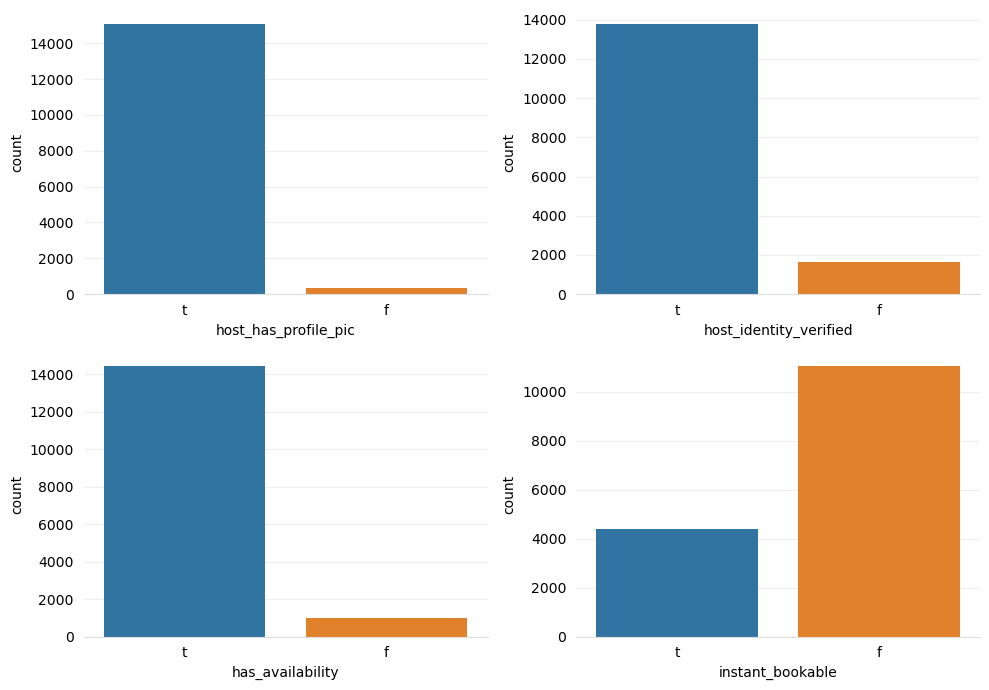

In [110]:
order = ['t', 'f']
# palette = {'t': '#E59462', 'f': '#D5CAE4'}

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
sns.countplot(df.host_has_profile_pic, x = 'host_has_profile_pic', ax = axs[0,0], order = order)# palette=palette
sns.countplot(df.host_identity_verified, x = 'host_identity_verified', ax = axs[0,1], order = order)
sns.countplot(df.has_availability, x  ='has_availability', ax=axs[1,0], order = order)
sns.countplot(df.instant_bookable, x = 'instant_bookable', ax=axs[1,1], order = order)

## axs as array

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
plt.tight_layout()

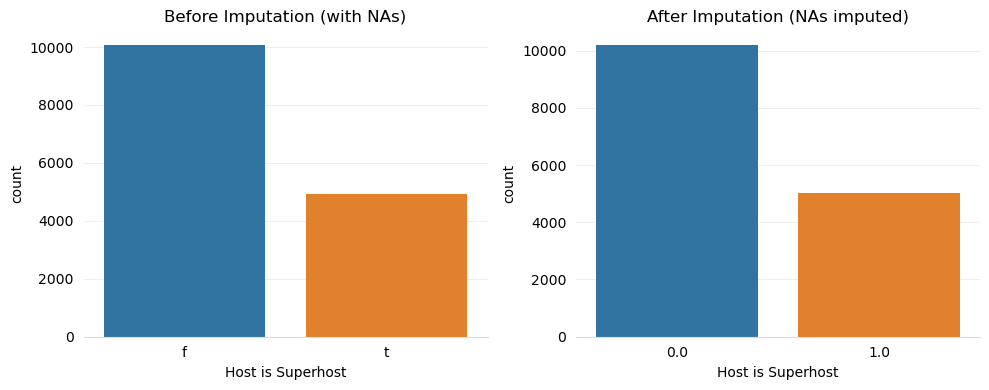

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
df["Industrial"] = df['Industrial'].fillna('M')

sns.countplot(data=df, x='host_is_superhost', ax=axs[0])
axs[0].set_title('Before Imputation (with NAs)')
axs[0].set_xlabel('Host is Superhost')
sns.countplot(data=df_clean, x='host_is_superhost', ax=axs[1])
axs[1].set_title('After Imputation (NAs imputed)')
axs[1].set_xlabel('Host is Superhost')

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
plt.tight_layout()

plt.show()

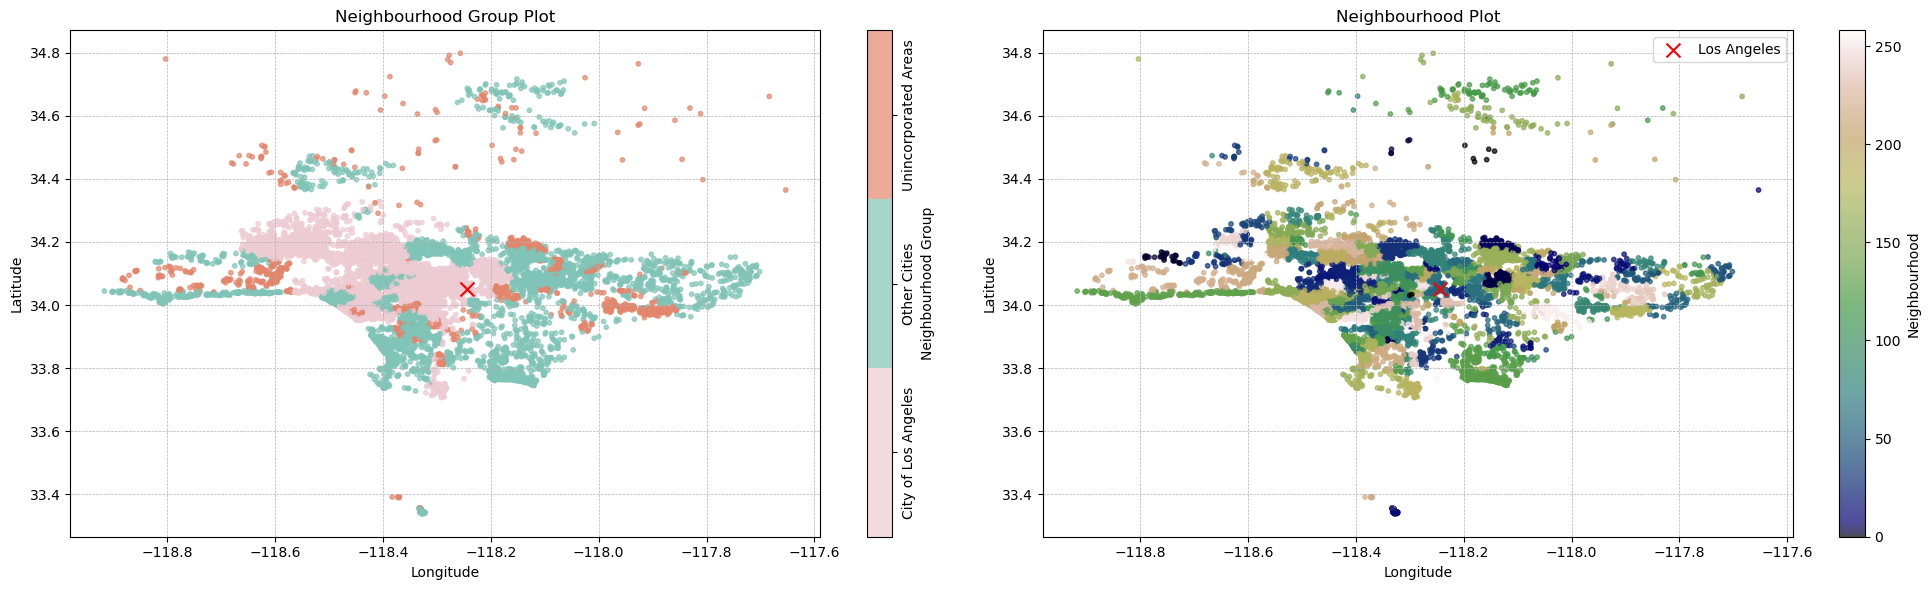

In [274]:
c1 = pd.Categorical(df['neighbourhood_cleansed'])
codes1 = c1.codes
c2 = pd.Categorical(df['neighbourhood_group_cleansed'])
codes2 = c2.codes

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
# neigborhood group
colors = ['#EDCBD2', '#80C4B7', '#E3856B']  
cmap = mcolors.ListedColormap(colors)
scatter2 = axs[0].scatter(df['longitude'], df['latitude'], c=codes2, 
                         s=10, marker='o', alpha=0.7, cmap=cmap)
axs[0].scatter(-118.2437, 34.0522, c='red', marker='x', s=100, label='Los Angeles')
axs[0].set_title('Neighbourhood Group Plot')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].grid(True, linestyle='--', linewidth=0.5)
cbar = plt.colorbar(scatter2, ax=axs[0], ticks=[0.333, 1, 1.667])
cbar.ax.set_yticklabels(c2.categories, rotation=90, verticalalignment='center')
cbar.set_label('Neighbourhood Group')


# Second plot (Neighbourhood)
scatter1 = axs[1].scatter(df['longitude'], df['latitude'], c=codes1, 
                         s=10, marker='o', alpha=0.7, cmap='gist_earth')
plt.colorbar(scatter1, ax=axs[1], label='Neighbourhood')
axs[1].scatter(-118.2437, 34.0522, c='red', marker='x', s=100, label='Los Angeles')
axs[1].set_title('Neighbourhood Plot')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].grid(True, linestyle='--', linewidth=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

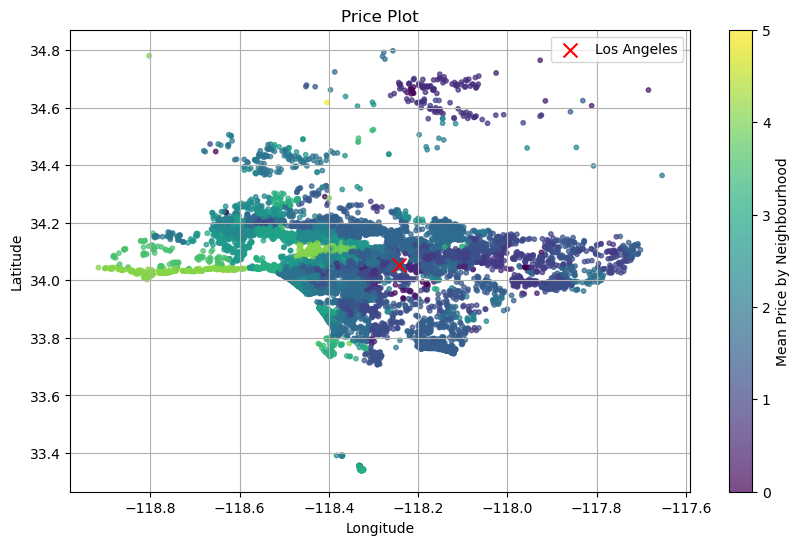

In [273]:
df_pri_plot = df.copy()
mean_prices = df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
mean_prices.rename(columns={'price': 'mean_price'}, inplace=True)
df_pri_plot = df_pri_plot.merge(mean_prices, on='neighbourhood_cleansed', how='left')
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pri_plot['longitude'], df_pri_plot['latitude'], c=df_pri_plot['mean_price'], 
                      s=10, marker='o', alpha=0.7, cmap='viridis')
plt.colorbar(scatter, label='Mean Price by Neighbourhood')
plt.scatter(-118.2437, 34.0522, c='red', marker='x', s=100, label='Los Angeles')
plt.title('Price Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()


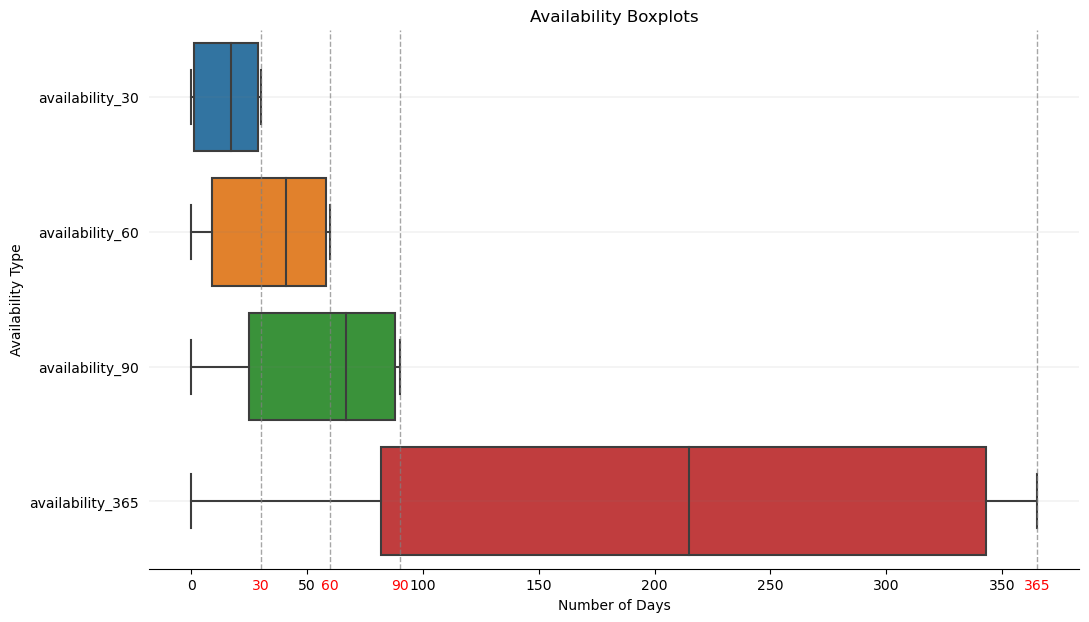

In [159]:

long_df = pd.melt(df, value_vars=['availability_30', 'availability_60', 'availability_90', 'availability_365'], var_name='Availability', value_name='Days')

fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(data=long_df, y='Availability', x='Days', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.axvline(x=30, color='grey', linestyle='--', linewidth=1, alpha=0.7)
ax.text(30, ax.get_ylim()[0]+0.075, '30', color='red', ha='center', va='top')
ax.axvline(x=60, color='grey', linestyle='--', linewidth=1, alpha=0.7)
ax.text(60, ax.get_ylim()[0]+0.075, '60', color='red', ha='center', va='top')
ax.axvline(x=90, color='grey', linestyle='--', linewidth=1, alpha=0.7)
ax.text(90, ax.get_ylim()[0]+0.075, '90', color='red', ha='center', va='top')
ax.axvline(x=365, color='grey', linestyle='--', linewidth=1, alpha=0.7)
ax.text(365, ax.get_ylim()[0]+0.075, '365', color='red', ha='center', va='top')

ax.set_title('Availability Boxplots')
plt.xlabel('Number of Days')
plt.ylabel('Availability Type')
plt.show()

In [351]:
df_clean.columns

Index(['host_id', 'host_since', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'description',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'amenities', 'veri_ema

In [358]:
desired_order = ['price', 'host_id', 'host_is_superhost', 
                    'host_identity_verified', 'host_has_profile_pic', 
                    'has_availability', 'instant_bookable', 
              'availability_30', 'availability_60', 'availability_90',
              'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'latitude', 'longitude', 'host_since', 
              'host_listings_count', 
              'host_total_listings_count', 
              'calculated_host_listings_count',
              'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms',
              'accommodates', 'beds_provid', 
              'minimum_nights', 'maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights',
              'minimum_maximum_nights', 'maximum_maximum_nights',
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
      'veri_phone', 'veri_email', 'veri_work_email',
      'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
      'property_type', 'room_type',
      'rating', 'beds_inname', 'bedrooms', 'bath_num', 'bath_share',
      'description', 'amenities']
df_clean = df_clean[desired_order]

### check the na and dtypes
info_df = pd.DataFrame({'DataType': df_clean.dtypes, 'NumOfNA': df_clean.isna().sum()})
print(df_clean.shape)
print(info_df)

(15209, 47)
                                              DataType  NumOfNA
price                                          float64        0
host_id                                        float64        0
host_is_superhost                              float64        0
host_identity_verified                         float64        0
host_has_profile_pic                           float64        0
has_availability                               float64        0
instant_bookable                               float64        0
availability_30                                float64        0
availability_60                                float64        0
availability_90                                float64        0
availability_365                               float64        0
number_of_reviews                              float64        0
number_of_reviews_ltm                          float64        0
number_of_reviews_l30d                         float64        0
latitude                    

In [ ]:
## missing values 
## host_is_superhost, bathrooms_text, description

## duplicate
## check duplicates
df['id'][df.id.duplicated()]
df['scrape_id'][df.scrape_id.duplicated()]
df['host_id'][df.host_id.duplicated()].shape ## (5854,) *******
df['host_name'][df.host_name.duplicated()].shape ##(11031,)

## data type
df.host_listings_count.isna().sum()

## drop: scrape_id, last_scraped, id
## tend to drop: picture_url, 

## Test

In [250]:
df_test = pd.read_csv('/Users/jiayi/Desktop/B_CS671/kaggle/test.csv')
print(df_test.shape)
df_test.columns

(6291, 47)


Index(['id', 'scrape_id', 'last_scraped', 'name', 'description', 'picture_url',
       'host_id', 'host_name', 'host_since', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'beds', 'amenities', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count

In [ ]:
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(X_train)

# Step 3: Transform the training data
X_train_imputed = imputer.transform(X_train)

# Step 3b: Transform the test data using the same imputer
X_test_imputed = imputer.transform(X_test)

In [359]:
l = df.host_is_superhost.replace({'t': 1, 'f': 0}).astype(float)
l

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
15436    0.0
15437    NaN
15438    1.0
15439    0.0
15440    0.0
Name: host_is_superhost, Length: 15441, dtype: float64

                                         Feature  Importance
37                                      bedrooms    0.117607
39                                    bath_share    0.105002
38                                      bath_num    0.102061
22                                  accommodates    0.036658
20  calculated_host_listings_count_private_rooms    0.032486
16                           host_listings_count    0.032215
27                        maximum_minimum_nights    0.026591
14                                     longitude    0.024546
5                               instant_bookable    0.023672
19   calculated_host_listings_count_entire_homes    0.023142
18                calculated_host_listings_count    0.022742
30                        minimum_nights_avg_ntm    0.022274
26                        minimum_minimum_nights    0.020866
28                        minimum_maximum_nights    0.020724
13                                      latitude    0.020140
17                     h

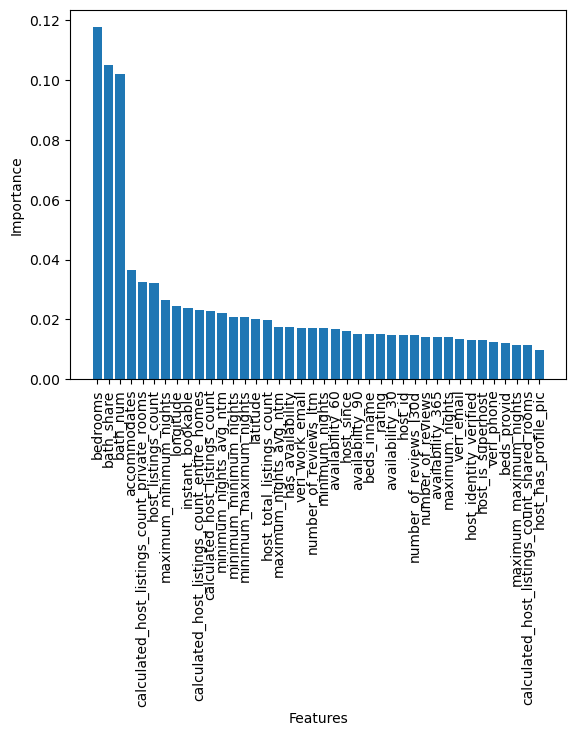

In [370]:
X = df_clean.select_dtypes(exclude=['object', 'category']).drop('price', axis=1)
y = df_clean['price']
model = XGBClassifier()
model.fit(X, y)

feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(features_df)

# Plotting Feature Importance
plt.bar(features_df['Feature'], features_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
## backup
def train_proprocess_2_(df):

    ## copy
    df_clean = df.copy()
    ## drop col and na row
    ## df_clean = df_clean.drop(['id', 'scrape_id', 'last_scraped', 'picture_url', 'calendar_last_scraped', 'host_name'], axis=1)
    df_clean = df_clean.drop(['id', 'scrape_id', 'last_scraped', 'picture_url', 'calendar_last_scraped', 'host_name',
                              'description', 'amenities'], axis=1)
    ## df_clean = df_clean.dropna(subset = ['description', 'bathrooms_text'])
    df_clean = df_clean.dropna(subset = ['bathrooms_text'])

    ## encode binary
    bin_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
    for col in bin_cols:
        df_clean[col] = encode_boolean(df_clean[col])
    
    
    ## convert date
    df_clean['host_since'] = get_days_since_date(df_clean['host_since'])




    ## impute*1: na
    df_imputed = mice_impute_numeric(df_clean)

    ## impute*2: outlier
    outlier_cols = ['beds', 'accommodates', 
                    'minimum_nights', 'maximum_nights', 
                    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
    for col in outlier_cols:
        df_imputed = outlier_to_na(df_imputed, col)
    df_imputed2 = mice_impute_numeric(df_imputed)
    ## subtle round
    df_imputed2['host_is_superhost'] = df_imputed2['host_is_superhost'].round()




    ## encode verification
    df_clean = split_and_encode_verification(df_imputed2)

    ## name convert
    dat_name = extract_name_column_info(df_clean)
    df_clean.rename(columns={
        'beds': 'beds_provid'}, inplace=True)
    df_clean = pd.concat((df_clean, dat_name), axis = 1)
    df_clean = df_clean.drop(['name', 'bathrooms_text'], axis=1)
    
    ##


    ## convert to category col
    cat_cols = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']
    for col in cat_cols:
        df_clean[col] = convert_to_category(df_clean[col])

    ## change col order
#     desired_order = ['price', 'host_id', 
#                     'host_is_superhost', 'host_identity_verified', 'host_has_profile_pic', 
#                     'has_availability', 'instant_bookable', 
#               'availability_30', 'availability_60', 'availability_90',
#               'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
#               'number_of_reviews_l30d', 'latitude', 'longitude', 'host_since', 
#               'host_listings_count', 
#               'host_total_listings_count', 
#               'calculated_host_listings_count',
#               'calculated_host_listings_count_entire_homes',
#               'calculated_host_listings_count_private_rooms',
#               'calculated_host_listings_count_shared_rooms',
#               'accommodates', 'beds_provid', 
#               'minimum_nights', 'maximum_nights',
#               'minimum_minimum_nights', 'maximum_minimum_nights',
#               'minimum_maximum_nights', 'maximum_maximum_nights',
#               'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
#       'veri_phone', 'veri_email', 'veri_work_email',
#       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
#       'property_type', 'room_type',
#       'rating', 'beds_inname', 'bedrooms', 'bath_num', 'bath_share',
#       'description', 'amenities']
#     df_clean = df_clean[desired_order]

    return df_clean

In [ ]:
df.